In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from collections import Counter
import yaml
import random
import numpy as np
import shutil
import pandas as pd
from collections import defaultdict

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
zip_path = "/content/drive/MyDrive/Military.zip"


In [8]:
import zipfile

extract_path = "/content/military_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Military dataset extracted successfully.")


✅ Military dataset extracted successfully.


In [ ]:
label_path = "/content/military_dataset/military_object_dataset/train/labels"

import os

class_ids = set()

for file in os.listdir(label_path):
    if file.endswith(".txt"):
        with open(os.path.join(label_path, file), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_ids.add(class_id)

print("✅ Total number of classes:", len(class_ids))
print("🆔 Class IDs found:", sorted(class_ids))


✅ Total number of classes: 12
🆔 Class IDs found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [ ]:
!cat /content/military_dataset/military_object_dataset/military_dataset.yaml


path: /kaggle/input/military-assets-dataset-12-classes-yolo8-format/military_object_dataset
test: test/images
train: train/images
val: val/images

names:
  0: camouflage_soldier
  1: weapon
  2: military_tank
  3: military_truck
  4: military_vehicle
  5: civilian
  6: soldier
  7: civilian_vehicle
  8: military_artillery
  9: trench
  10: military_aircraft
  11: military_warship


EXPLORATARY ANALYSIS

**Image analysis**

**Image size and resolution**

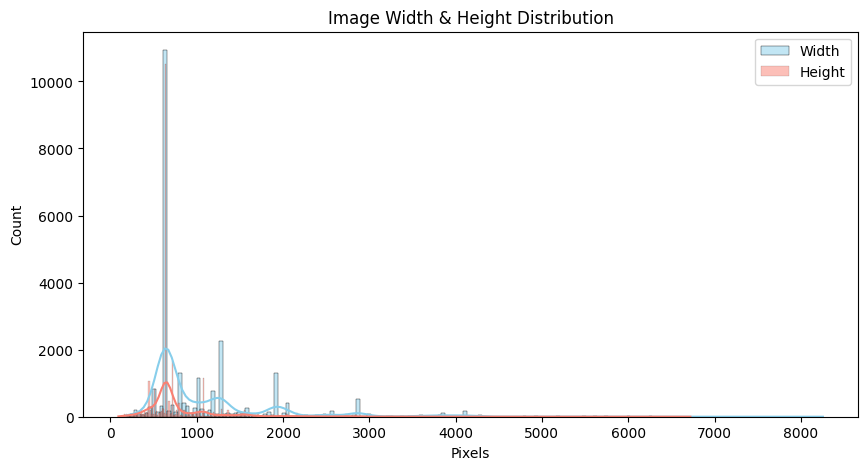

In [ ]:


# Get all image paths
base_path = "/content/military_dataset/military_object_dataset"
image_paths = [
    os.path.join(base_path, split, "images", f)
    for split in ["train", "val", "test"]
    for f in os.listdir(os.path.join(base_path, split, "images"))
    if f.lower().endswith(('.jpg', '.png', '.jpeg'))
]

# Get image dimensions
dims = [cv2.imread(p).shape[:2] for p in image_paths if cv2.imread(p) is not None]
heights, widths = zip(*dims)

# Plot
plt.figure(figsize=(10,5))
sns.histplot(widths, color="skyblue", kde=True, label="Width")
sns.histplot(heights, color="salmon", kde=True, label="Height")
plt.xlabel("Pixels")
plt.title("Image Width & Height Distribution")
plt.legend()
plt.show()


**Aspect ratio**

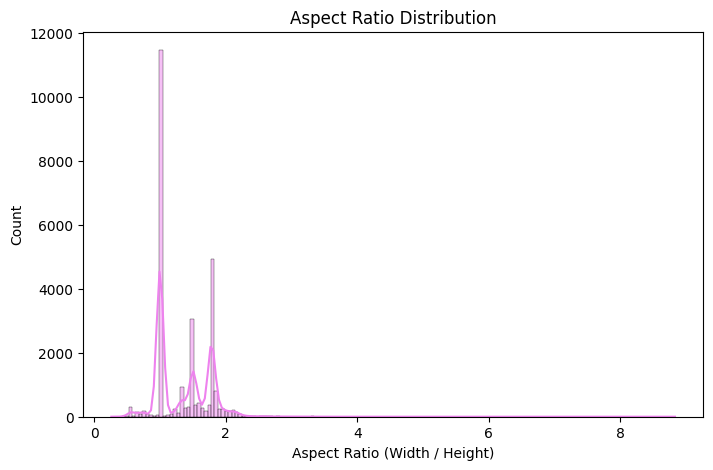

In [ ]:
# Calculate aspect ratios
aspect_ratios = [round(w/h, 2) for h, w in dims]

# Plot
plt.figure(figsize=(8,5))
sns.histplot(aspect_ratios, kde=True, color="violet")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.title("Aspect Ratio Distribution")
plt.show()


**Image quality**


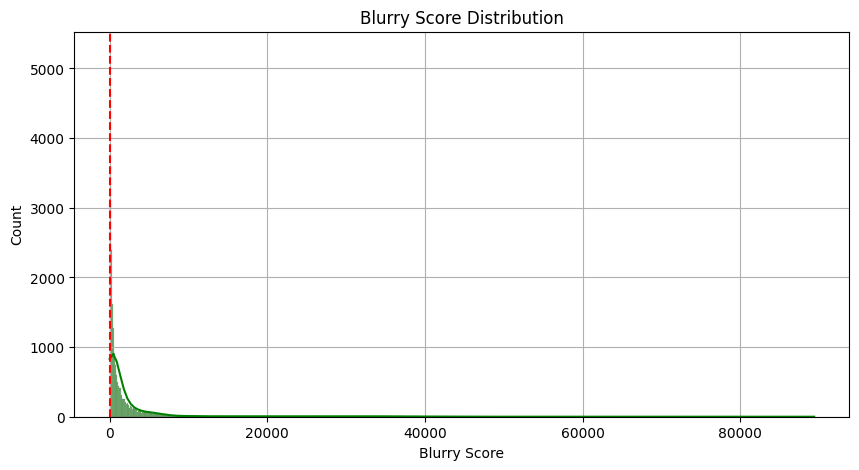

In [ ]:
def is_blurry(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    score = cv2.Laplacian(gray, cv2.CV_64F).var()
    return score, score < threshold


blurry_score = []
blurry_count = 0

for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        score, is_blurry_img = is_blurry(img)
        blurry_score.append(score)
        blurry_count += is_blurry_img

#plot
plt.figure(figsize=(10,5))
sns.histplot(blurry_score, kde=True, color="green")
plt.axvline(x=100, color='r', linestyle='--')
plt.xlabel("Blurry Score")
plt.title("Blurry Score Distribution")
plt.grid(True)
plt.show()

Annotation analysis

**Number of annotation per image**


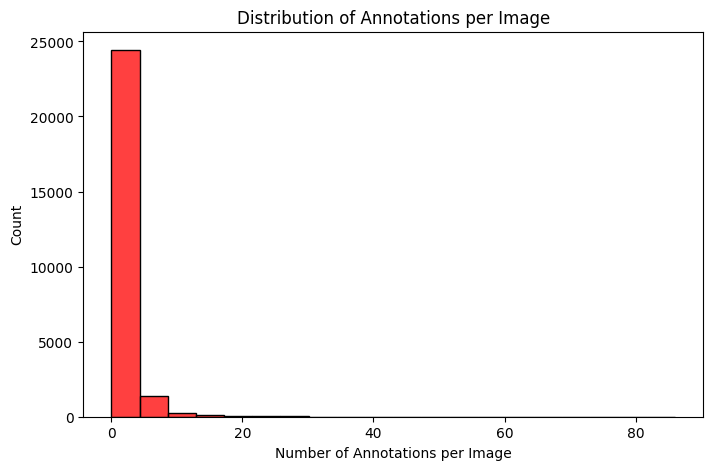

In [ ]:

label_dirs = [
    "/content/military_dataset/military_object_dataset/train/labels",
    "/content/military_dataset/military_object_dataset/val/labels",
    "/content/military_dataset/military_object_dataset/test/labels"
]
num_annotations = []

for label_dir in label_dirs:
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            with open(os.path.join(label_dir, label_file), "r") as f:
                lines = f.readlines()
                num_annotations.append(len(lines))

#plot
plt.figure(figsize=(8,5))
sns.histplot(num_annotations, bins=20, kde=False, color="red")
plt.xlabel("Number of Annotations per Image")
plt.ylabel("Count")
plt.title("Distribution of Annotations per Image")
plt.show()

**Bounding box size distribution**

Skipping invalid line in 000003.txt: 0 camouflage_soldier.334375 camouflage_soldier.3953125 0.10078125 0.459375


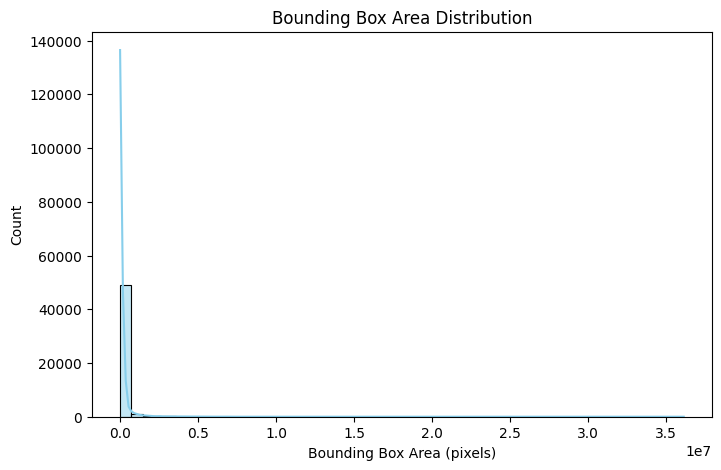

In [ ]:

label_dirs = [
    "/content/military_dataset/military_object_dataset/train/labels",
    "/content/military_dataset/military_object_dataset/val/labels",
    "/content/military_dataset/military_object_dataset/test/labels"
]
img_dirs = [
    "/content/military_dataset/military_object_dataset/train/images",
    "/content/military_dataset/military_object_dataset/val/images",
    "/content/military_dataset/military_object_dataset/test/images"
]

areas = []

for i, label_dir in enumerate(label_dirs):
    img_dir = img_dirs[i]
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            img_path = os.path.join(img_dir, label_file.replace(".txt", ".jpg"))
            if not os.path.exists(img_path):
                img_path = img_path.replace(".jpg", ".png")
            img = cv2.imread(img_path)
            if img is None:
                continue
            h, w = img.shape[:2]

            with open(os.path.join(label_dir, label_file), "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        try:
                            cls, xc, yc, bw, bh = map(float, parts[:5])
                            area = (bw * w) * (bh * h)
                            areas.append(area)
                        except ValueError:
                            print(f"Skipping invalid line in {label_file}: {line.strip()}")
                    else:
                        print(f"Skipping malformed line in {label_file}: {line.strip()}")

#plot
plt.figure(figsize=(8,5))
sns.histplot(areas, bins=50, kde=True, color="skyblue")
plt.xlabel("Bounding Box Area (pixels)")
plt.title("Bounding Box Area Distribution")
plt.show()

**Bounding box aspect ratio**

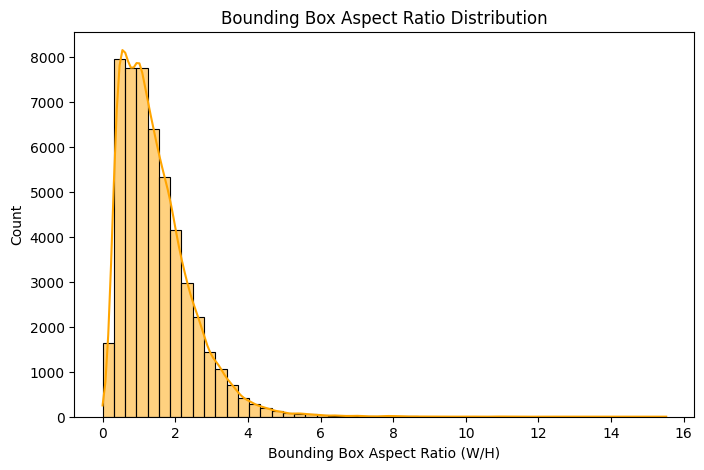

⚠ Skipped 1 invalid lines from labels.


In [ ]:


label_dirs = [
    "/content/military_dataset/military_object_dataset/train/labels",
    "/content/military_dataset/military_object_dataset/val/labels",
    "/content/military_dataset/military_object_dataset/test/labels"
]

img_dirs = [
    "/content/military_dataset/military_object_dataset/train/images",
    "/content/military_dataset/military_object_dataset/val/images",
    "/content/military_dataset/military_object_dataset/test/images"
]

aspect_ratios = []
skipped_lines = 0

for label_dir, img_dir in zip(label_dirs, img_dirs):
    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"):
            continue

        img_path = os.path.join(img_dir, label_file.rsplit(".", 1)[0] + ".jpg")
        if not os.path.exists(img_path):
            img_path = img_path.replace(".jpg", ".png")
        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w = img.shape[:2]

        with open(os.path.join(label_dir, label_file)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    try:
                        _, xc, yc, bw, bh = map(float, parts[:5])
                        if bh > 0:
                            aspect_ratios.append((bw * w) / (bh * h))
                    except ValueError:
                        skipped_lines += 1

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(aspect_ratios, bins=50, kde=True, color="orange")
plt.xlabel("Bounding Box Aspect Ratio (W/H)")
plt.title("Bounding Box Aspect Ratio Distribution")
plt.show()

print(f"⚠ Skipped {skipped_lines} invalid lines from labels.")


Class distribution

**Class frequency**

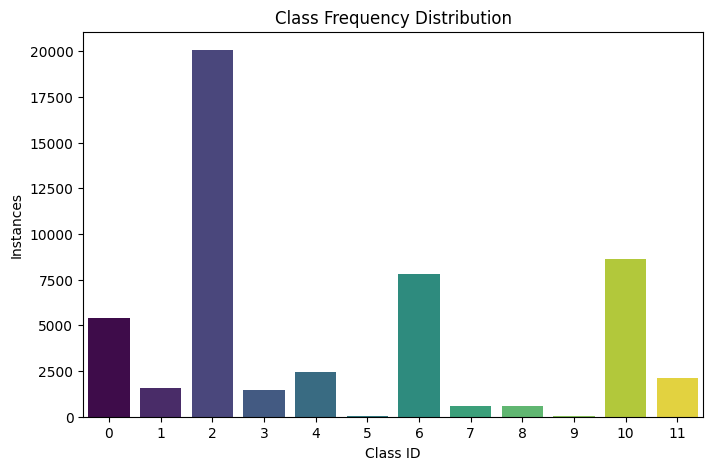

In [ ]:

label_dirs = [
    "/content/military_dataset/military_object_dataset/train/labels",
    "/content/military_dataset/military_object_dataset/val/labels",
    "/content/military_dataset/military_object_dataset/test/labels"
]

class_counts = Counter()

for label_dir in label_dirs:
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 0 and parts[0].isdigit():
                        class_counts[int(parts[0])] += 1

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis",hue=list(class_counts.keys()),legend=False)
plt.xlabel("Class ID")
plt.ylabel("Instances")
plt.title("Class Frequency Distribution")
plt.show()


**Class Co-occurrence**

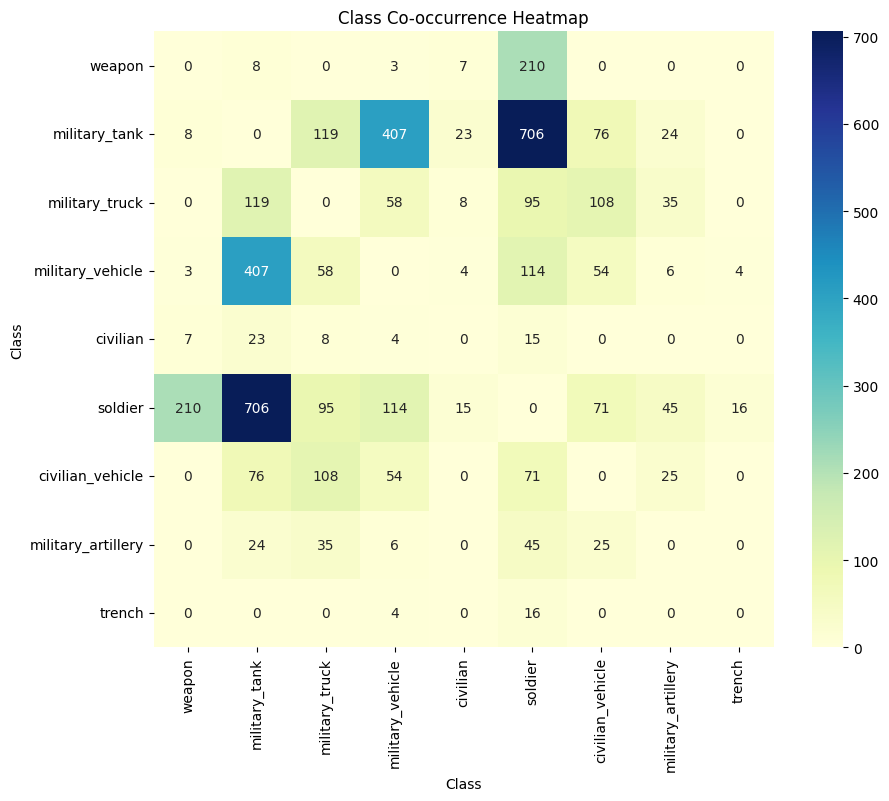

In [ ]:


# Paths
base_dir = '/content/military_dataset/military_object_dataset'
yaml_path = '/content/military_dataset/military_object_dataset/military_dataset.yaml'

# Load class names from YAML
with open(yaml_path, 'r') as f:
    names = yaml.safe_load(f)['names']

# Count co-occurrences
co_occurrence = defaultdict(int)
for split in ['train', 'val', 'test']:
    label_dir = os.path.join(base_dir, split, 'labels')
    if not os.path.exists(label_dir):
        print(f"Warning: Label directory not found: {label_dir}")
        continue
    for file in os.listdir(label_dir):
        if file.endswith('.txt'):
            with open(os.path.join(label_dir, file)) as f:
                class_ids = sorted({int(line.split()[0]) for line in f if line.strip() and line.split()[0].isdigit()})
                for i in class_ids:
                    for j in class_ids:
                        if i != j:
                            co_occurrence[(i, j)] += 1


classes = sorted(set(cls for pair in co_occurrence for cls in pair))
size = len(classes)
matrix = np.zeros((size, size), dtype=int)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

for (i, j), count in co_occurrence.items():
    if i in class_to_idx and j in class_to_idx:
        matrix[class_to_idx[i]][class_to_idx[j]] = count
    else:
        print(f"Warning: Skipping co-occurrence for unknown class pair ({i}, {j})")


# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(matrix, index=[names.get(i, f"Class {i}") for i in classes],
                         columns=[names.get(i, f"Class {i}") for i in classes]),
            annot=True, fmt='d', cmap='YlGnBu')
plt.title('Class Co-occurrence Heatmap')
plt.xlabel('Class')
plt.ylabel('Class')
plt.show()

sample images with annotations

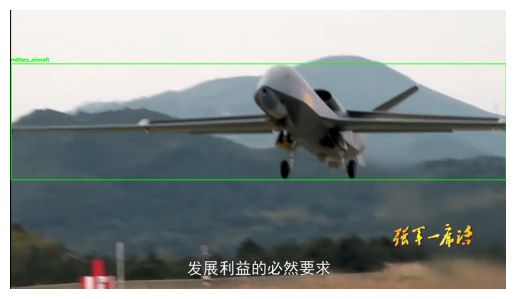

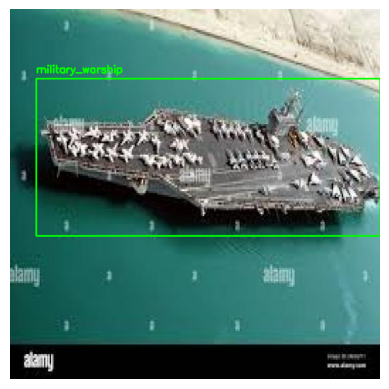

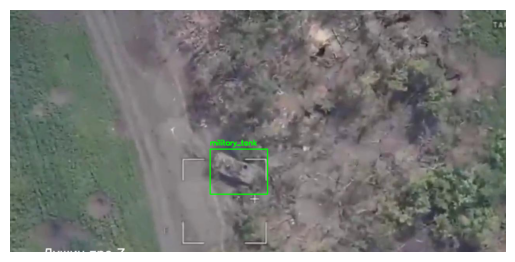

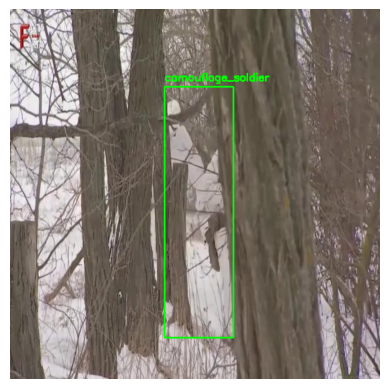

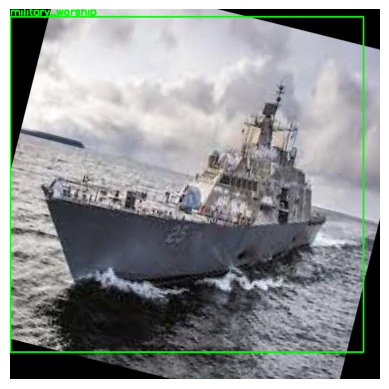

In [9]:


# Load class names from YAML
yaml_path = "/content/military_dataset/military_object_dataset/military_dataset.yaml"
with open(yaml_path) as f:
    names = yaml.safe_load(f)["names"]

splits = ["train", "val", "test"]
img_dirs = [f"/content/military_dataset/military_object_dataset/{s}/images" for s in splits]
label_dirs = [f"/content/military_dataset/military_object_dataset/{s}/labels" for s in splits]

# Function to draw boxes
def draw_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    if img is None:
        return
    h, w = img.shape[:2]
    with open(label_path) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())
            x1, y1 = int((xc - bw/2) * w), int((yc - bh/2) * h)
            x2, y2 = int((xc + bw/2) * w), int((yc + bh/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img, names[int(cls)], (x1, max(y1-10, 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Collect all images across splits
all_images = []
for img_dir, label_dir in zip(img_dirs, label_dirs):
    for img_file in os.listdir(img_dir):
        if img_file.lower().endswith(('.jpg', '.png')):
            label_file = os.path.splitext(img_file)[0] + ".txt"
            if os.path.exists(os.path.join(label_dir, label_file)):
                all_images.append((os.path.join(img_dir, img_file),
                                   os.path.join(label_dir, label_file)))

# Show 5 random samples
for img_path, label_path in random.sample(all_images, 5):
    draw_boxes(img_path, label_path)


Heatmaps

Skipping line with invalid float in 000003.txt: 0 camouflage_soldier.334375 camouflage_soldier.3953125 0.10078125 0.459375


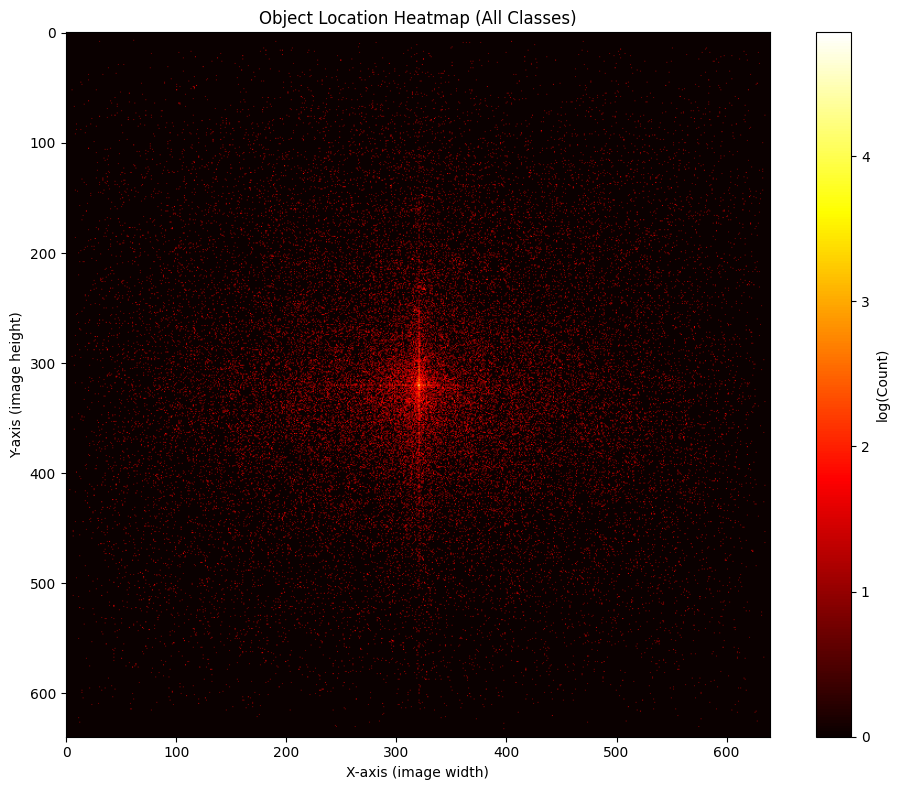

In [ ]:


# Label directories for all splits
label_dirs = [
    "/content/military_dataset/military_object_dataset/train/labels",
    "/content/military_dataset/military_object_dataset/val/labels",
    "/content/military_dataset/military_object_dataset/test/labels"
]

heatmap = np.zeros((640, 640))

for label_dir in label_dirs:
    for file in os.listdir(label_dir):
        if file.endswith('.txt'):
            with open(os.path.join(label_dir, file)) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        try:
                            _, x, y, _, _ = map(float, parts[:5])
                            cx, cy = int(x * 640), int(y * 640)
                            if 0 <= cx < 640 and 0 <= cy < 640:
                                heatmap[cy, cx] += 1
                        except ValueError:
                            print(f"Skipping line with invalid float in {file}: {line.strip()}")
                            continue
                    else:
                        print(f"Skipping malformed line in {file}: {line.strip()}")
                        continue


# Apply log scaling
heatmap_log = np.log1p(heatmap)

plt.figure(figsize=(10, 8))
plt.imshow(heatmap_log, cmap='hot')
plt.colorbar(label='log(Count)')
plt.title('Object Location Heatmap (All Classes)')
plt.xlabel('X-axis (image width)')
plt.ylabel('Y-axis (image height)')
plt.tight_layout()
plt.show()

class-wise bounding box distribution

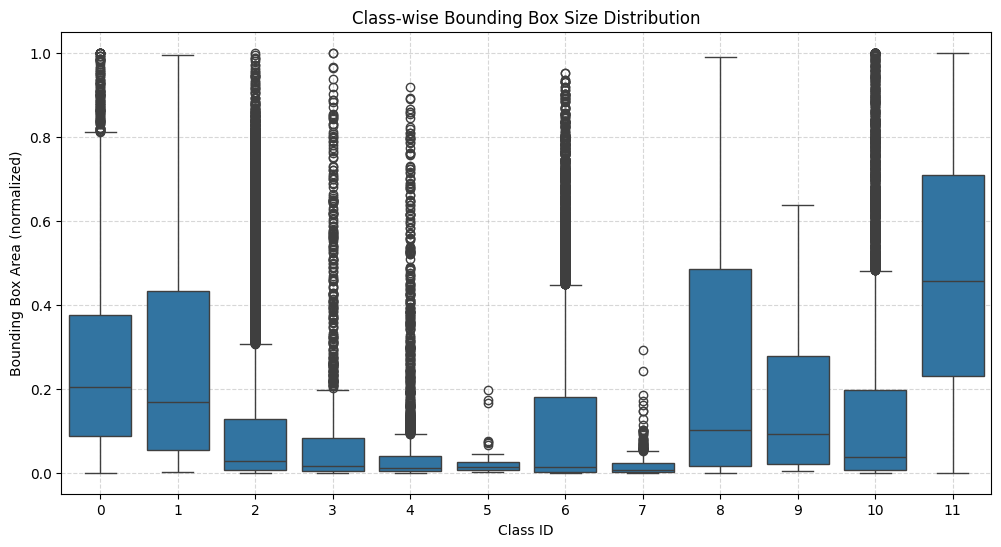

In [ ]:

# Label directories
label_dirs = [
    "/content/military_dataset/military_object_dataset/train/labels",
    "/content/military_dataset/military_object_dataset/val/labels",
    "/content/military_dataset/military_object_dataset/test/labels"
]

bbox_data = []

# Read all bounding boxes and store (class_id, area)
for label_dir in label_dirs:
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            with open(os.path.join(label_dir, label_file)) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        try:
                            cls, _, _, w, h = map(float, parts[:5])
                            area = w * h
                            bbox_data.append((int(cls), area))
                        except ValueError:
                            continue

# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(bbox_data, columns=["Class ID", "BBox Area"])

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Class ID", y="BBox Area", data=df)
plt.title("Class-wise Bounding Box Size Distribution")
plt.xlabel("Class ID")
plt.ylabel("Bounding Box Area (normalized)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:

# Label directories
label_dirs = [
    "/content/military_dataset/military_object_dataset/train/labels",
    "/content/military_dataset/military_object_dataset/val/labels",
    "/content/military_dataset/military_object_dataset/test/labels"
]

for label_dir in label_dirs:
    print(f"\n🔍 Processing: {label_dir}")

    for filename in os.listdir(label_dir):
        if filename.endswith(".txt"):
            filepath = os.path.join(label_dir, filename)

            backup_path = filepath + ".bak"
            shutil.copy(filepath, backup_path)

            with open(filepath, "r") as f:
                lines = f.readlines()

            cleaned_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    try:
                        floats = list(map(float, parts[:5]))
                        cleaned_lines.append(" ".join(f"{v:.6f}" for v in floats))
                    except ValueError:
                        print(f"❌ Invalid values in {filename}: {line.strip()}")
                else:
                    print(f"⚠️ Skipped malformed line in {filename}: {line.strip()}")

            with open(filepath, "w") as f:
                for cl in cleaned_lines:
                    f.write(cl + "\n")

print("\n✅ All label files cleaned for train, val, and test.")



🔍 Processing: /content/military_dataset/military_object_dataset/train/labels

🔍 Processing: /content/military_dataset/military_object_dataset/val/labels

🔍 Processing: /content/military_dataset/military_object_dataset/test/labels
❌ Invalid values in 000003.txt: 0 camouflage_soldier.334375 camouflage_soldier.3953125 0.10078125 0.459375

✅ All label files cleaned for train, val, and test.


In [ ]:


base_dir = '/content/military_dataset/military_object_dataset'
splits = ['train', 'val', 'test']

for split in splits:
    img_dir = os.path.join(base_dir, split, 'images')
    label_dir = os.path.join(base_dir, split, 'labels')
    img_count = len([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
    label_count = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])
    print(f"{split.capitalize()} Set: {img_count} images, {label_count} labels")

Train Set: 21978 images, 21978 labels
Val Set: 2941 images, 2941 labels
Test Set: 1396 images, 1396 labels


In [ ]:


def class_distribution(label_path):
    counter = Counter()
    for file in os.listdir(label_path):
        if file.endswith('.txt'):
            with open(os.path.join(label_path, file), 'r') as f:
                for line in f:
                    class_id = line.strip().split()[0]
                    counter[int(float(class_id))] += 1
    return counter

base_dir = '/content/military_dataset/military_object_dataset'
splits = ['train', 'val', 'test']

for split in splits:
    label_path = os.path.join(base_dir, split, 'labels')
    print(f"\n{split.capitalize()} Set Class Distribution:")
    dist = class_distribution(label_path)
    for cls, count in dist.items():
        print(f"Class {cls}: {count}")


Train Set Class Distribution:
Class 0: 4477
Class 10: 7337
Class 2: 17454
Class 6: 6502
Class 11: 2134
Class 1: 1210
Class 4: 1963
Class 3: 1245
Class 7: 519
Class 8: 439
Class 5: 52
Class 9: 4

Val Set Class Distribution:
Class 10: 1063
Class 6: 745
Class 2: 1787
Class 0: 510
Class 1: 358
Class 8: 117
Class 4: 307
Class 3: 148
Class 7: 42
Class 5: 1
Class 9: 3

Test Set Class Distribution:
Class 2: 818
Class 0: 388
Class 6: 560
Class 4: 194
Class 3: 96
Class 8: 50
Class 10: 236
Class 9: 37
Class 7: 25


In [ ]:


# Keep only these classes
keep_classes = {2, 10}


base_dir = "/content/military_dataset/military_object_dataset"
splits = ["train", "val", "test"]

for split in splits:
    label_dir = os.path.join(base_dir, split, "labels")
    if not os.path.exists(label_dir):
        continue
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            path = os.path.join(label_dir, file)
            new_lines = []
            with open(path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if parts and int(float(parts[0])) in keep_classes:
                        new_lines.append(line)

            with open(path, "w") as f:
                f.writelines(new_lines)

print("✅ Labels filtered")


✅ Labels filtered


In [ ]:


# Classes to keep
class_map = {2: 0, 10: 1}

splits = ["train", "val", "test"]
base_dir = "/content/military_dataset/military_object_dataset"

for split in splits:
    label_dir = os.path.join(base_dir, split, "labels")
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            new_lines = []
            with open(os.path.join(label_dir, file)) as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    cls_id = int(float(parts[0]))
                    if cls_id in class_map:
                        parts[0] = str(class_map[cls_id])
                        new_lines.append(" ".join(parts) + "\n")
            with open(os.path.join(label_dir, file), "w") as f:
                f.writelines(new_lines)

print("✅ Dataset filtered: only classes 2 and 10 remain (mapped to 0 and 1).")


✅ Dataset filtered: only classes 2 and 10 remain (mapped to 0 and 1).


In [ ]:
# Create the custom_military_dataset.yaml file
yaml_content = """train: /content/military_dataset/military_object_dataset/train/images
val: /content/military_dataset/military_object_dataset/val/images

nc: 2
names: ['military_tank', 'military_aircraft']
"""

with open('/content/custom_military_dataset.yaml', 'w') as f:
    f.write(yaml_content)

print("✅ custom_military_dataset.yaml created successfully.")

✅ custom_military_dataset.yaml created successfully.


Augmentation

In [ ]:

import albumentations as A

# augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.1))

# Paths
img_dir = "/content/military_dataset/military_object_dataset/train/images"
label_dir = "/content/military_dataset/military_object_dataset/train/labels"
out_img_dir = "/content/augmented/images"
out_lbl_dir = "/content/augmented/labels"
os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_lbl_dir, exist_ok=True)

# Loop through label files
for label_file in os.listdir(label_dir):
    if not label_file.endswith('.txt'):
        continue

    img_name = label_file.replace('.txt', '.jpg')
    img_path = os.path.join(img_dir, img_name)
    if not os.path.exists(img_path):
        continue

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bboxes = []
    class_labels = []
    with open(os.path.join(label_dir, label_file)) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.strip().split())

            x_min = xc - bw / 2
            y_min = yc - bh / 2
            x_max = xc + bw / 2
            y_max = yc + bh / 2

            x_min = max(0.0, min(1.0, x_min))
            y_min = max(0.0, min(1.0, y_min))
            x_max = max(0.0, min(1.0, x_max))
            y_max = max(0.0, min(1.0, y_max))

            xc = (x_min + x_max) / 2
            yc = (y_min + y_max) / 2
            bw = x_max - x_min
            bh = y_max - y_min

            if bw < 0.001 or bh < 0.001:
                continue

            bboxes.append([xc, yc, bw, bh])
            class_labels.append(int(cls))

    if not bboxes:
        continue

    try:
        aug = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = aug['image']
        aug_bboxes = aug['bboxes']
        aug_labels = aug['class_labels']
    except Exception as e:
        print(f"⚠️ Skipping {img_name} due to error: {e}")
        continue

    # Save augmented image and label
    out_img_path = os.path.join(out_img_dir, img_name.replace('.jpg', '_aug.jpg'))
    out_lbl_path = os.path.join(out_lbl_dir, label_file.replace('.txt', '_aug.txt'))

    cv2.imwrite(out_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
    with open(out_lbl_path, 'w') as f:
        for cls, box in zip(aug_labels, aug_bboxes):
            f.write(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")

print("✅ Augmentation done.")

✅ Augmentation done.


In [ ]:
from ultralytics import YOLO

# 1️⃣ Load model
model = YOLO("yolov8n.pt")

# 2️⃣ Train the model
model.train(
    data='/content/custom_military_dataset.yaml',
    epochs=30,
    patience=5,
    imgsz=640,
    batch=12,
    name="military_model_yolo8",
    save_period=5
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_military_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e4b9d485e80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
import time


# Load your trained model
model_path = "/content/runs/detect/military_model_yolo8/weights/best.pt"
model = YOLO(model_path)

# Evaluate the model
results = model.val(plots=True, conf=0.3)

# Per-class metrics
precisions = results.box.p
recalls = results.box.r
map50s = results.box.map50
maps = results.box.map

print("\n--- Evaluation Metrics ---")
print(f"Overall mAP50: {map50s:.3f}")
print(f"Overall mAP50-95: {maps:.3f}")

if precisions is not None and len(precisions) > 0:
    print("\n--- Per-Class Metrics ---")
    for cls_id, cls_name in results.names.items():
        if cls_id < len(precisions) and cls_id < len(recalls):
             print(f"{cls_name}: Precision={precisions[cls_id]:.3f}, Recall={recalls[cls_id]:.3f}")


test_img_dir = "/content/military_dataset/military_object_dataset/test/images"
img_files = [f for f in os.listdir(test_img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
if img_files:
    img_path = os.path.join(test_img_dir, random.choice(img_files))
else:
    img_path = None
    print("Error: No images found in the test directory.")


if img_path:
    # GPU timing
    times = []
    for _ in range(50):
        start = time.time()
        model.predict(img_path, device=0, verbose=False)
        times.append(time.time() - start)
    gpu_time = sum(times) / len(times)

    # CPU timing
    times = []
    for _ in range(50):
        start = time.time()
        model.predict(img_path, device="cpu", verbose=False)
        times.append(time.time() - start)
    cpu_time = sum(times) / len(times)

    print(f"⚡ GPU Avg Inference: {gpu_time:.4f}s ({1/gpu_time:.2f} FPS)")
    print(f"🖥️ CPU Avg Inference: {cpu_time:.4f}s ({1/cpu_time:.2f} FPS)")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1408.5±927.0 MB/s, size: 92.5 KB)
val: Scanning /content/military_dataset/military_object_dataset/val/labels.cache... 2941 images, 1409 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2941/2941 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 184/184 4.9it/s 37.2s
                   all       2941       2850      0.868      0.809      0.867      0.675
         military_tank        938       1787      0.832      0.819      0.848       0.62
     military_aircraft        594       1063      0.903        0.8      0.886      0.731
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/runs/detect/val

--- Evaluation Metrics ---
Overall mAP50: 0.867
Overall mAP50-9

STREAMLIT

In [ ]:
!pip install streamlit ultralytics
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image
import io, time

# Load model
@st.cache_resource
def load_model():
    return YOLO("/content/runs/detect/military_model_yolo8/weights/best.pt")
model = load_model()

st.set_page_config(page_title="Military Detection", page_icon="🛰️")
st.title("🛰️Military Object Detection")
st.write("Upload an image to detect threats")

file = st.file_uploader("Upload Image", ["jpg","jpeg","png"])
if file:
    img = Image.open(file).convert("RGB")

    # Inference
    t0 = time.time()
    res = model.predict(img, conf=0.25, verbose=False)[0]
    t = time.time() - t0
    out = res.plot()[:, :, ::-1]
    st.image(out, caption=f"Detections | {t:.2f}s ({1/t:.1f} FPS)", use_container_width=True)
    st.subheader(":blue[📊 Results]")
    if len(res.boxes):
        for box in res.boxes:
            st.write(f"- **{res.names[int(box.cls)]}** ({float(box.conf):.2f})")
    else:
        st.warning("No objects detected!")

    buf = io.BytesIO()
    Image.fromarray(out).save(buf, "PNG")
    st.download_button("⬇️ Download Result", buf.getvalue(), "result.png")
    st.write("Downloded successfully")

Writing app.py


In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.228.131:8501



In [ ]:
from pyngrok import ngrok
kill_ngrok = ngrok.kill()

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("322lGXlqGiRNi86sBSXx0Dej5Hv_3xfyKiAparnKrdYSwAaja")
public_url = ngrok.connect(8501)
print(public_url)